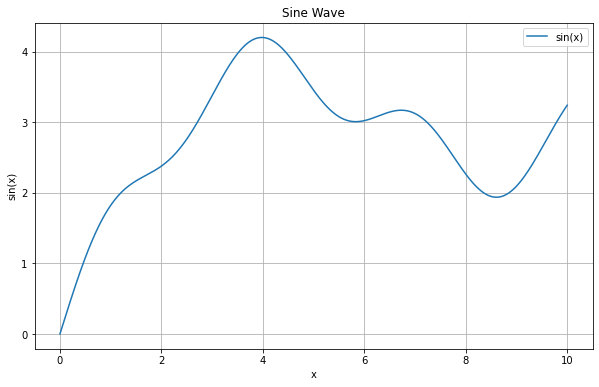

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to 2*pi
x = np.linspace(0, 10, 1000)

# Compute the y values as the sine of x
y = 0.4*np.sin(2*x) + 2*np.sin(0.5*x) + 10*np.sin(0.05*x)   ## x is your timestep.  the x coefficients are the additive bits.  the sin coeffs are learned.
#y = np.sin(0.1*x) #this is dope cuz do it additively
##pass in the time step, so like your target is x in length.  give that as an input, learn the function.

#at inference tell it the x, the time you want.  
#i think this might just be a layer you tack on at the end, before inference.  
#yeah, you have lets say 10 frequencies, each of them being higher than the previous (add the previous frequencies to get the next)
#then you have the sin coefficients that correspond to each frequency, then you have your x which is just something that corresponds to the length of the output
#you could do multiple of these things together.  add em all at the end.  what would each thing learn.  that would be interesting.  they would have meaning individually maybe?
#inputs are words, outputs are soundwaves.  no time.  

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='sin(x)')

# Add titles and labels
plt.title('Sine Wave')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


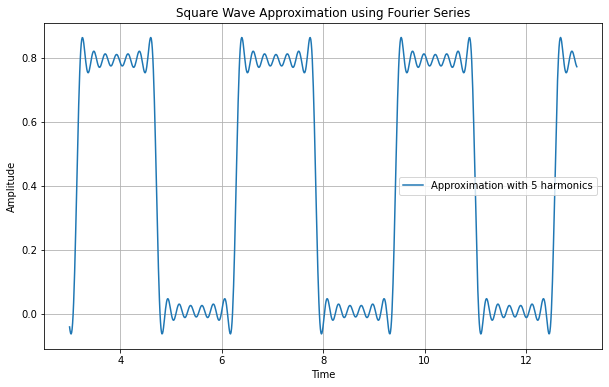

In [2]:
# repetitions
t = np.linspace(0, 10, 1000) #means range from 0 to 10, make 1000 of em.  this is derived from output.  sample rate, lenght of recording
omega = 2 #this is learned i think? the speed? maybe? input specific
t = t+3  ## t moves it along x axis. This is offset.  input specific
# Explicit sum of the first five odd harmonics
square_wave = 0.5* (
    np.sin(omega* t) +
    (1 / 3) * np.sin(3* omega * t) +
    (1 / 5) * np.sin(5* omega * t) +
    (1 / 7) * np.sin(7* omega *  t) +
    (1 / 9) * np.sin(9* omega *  t) + 
     (1 / 11) * np.sin(11* omega *  t) + 
     (1 / 13) * np.sin(13* omega *  t) #more harmonics (these odd number thingys, higher resolution, more square)
) +0.4

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, square_wave, label='Approximation with 5 harmonics')
plt.title('Square Wave Approximation using Fourier Series')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

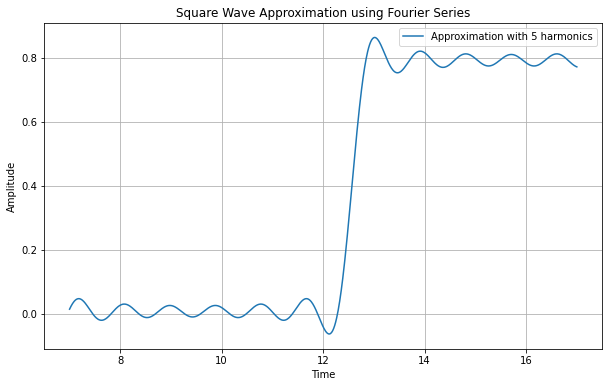

In [3]:
omega = 0.5
t = t+4 ## t moves it along x axis. ##this needs to be data point specific and move all of them.  
# Explicit sum of the first five odd harmonics
square_wave_2 = 0.5* (
    np.sin(omega* t) +
    (1 / 3) * np.sin(3* omega * t) +
    (1 / 5) * np.sin(5* omega * t) +
    (1 / 7) * np.sin(7* omega *  t) +
    (1 / 9) * np.sin(9* omega *  t) + 
     (1 / 11) * np.sin(11* omega *  t) + 
     (1 / 13) * np.sin(13* omega *  t) #more harmonics (these odd number thingys, higher resolution, more square)
) + 0.4

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, square_wave_2, label='Approximation with 5 harmonics')
plt.title('Square Wave Approximation using Fourier Series')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

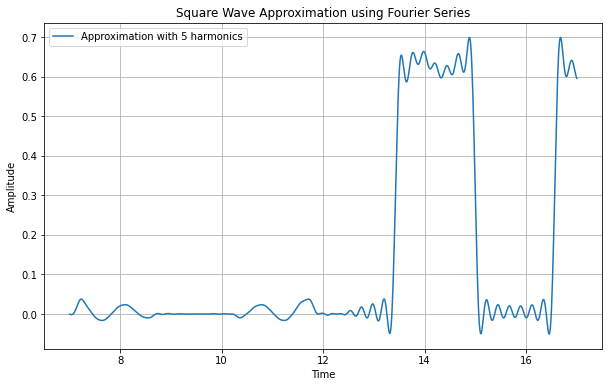

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, square_wave_2*square_wave, label='Approximation with 5 harmonics')
plt.title('Square Wave Approximation using Fourier Series')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
how do you stack these? add inside, then multiply? or something? ask kulis.  maybe im looney.  



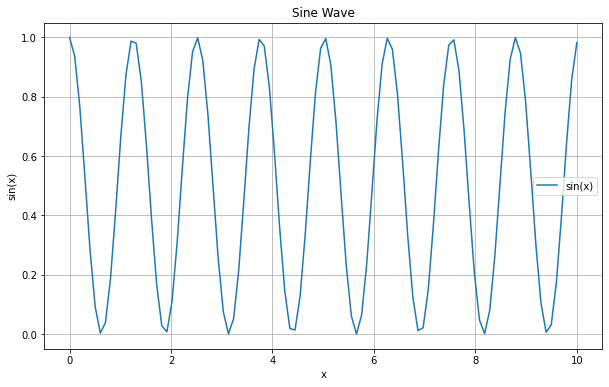

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to 2*pi
x = np.linspace(0, 10, 100)

# Compute the y values as the sine of x
## y = 1*np.sin(0.*x+4.57)    ## x is your timestep.  the x coefficients are the additive bits.  the sin coeffs are learned.
y =0.5 * np.sin(5*x+1.5703) + 0.5  ## this can learn 0 and 1, you could freeze the 0.5s, and just make these selectors?

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='sin(x)')

# Add titles and labels
plt.title('Sine Wave')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
## now, i want to what.  use the matrices to parameterize the sine combinations? ye
i think if it can learn an offset at everystage (inluding an input that is persisted) it could work.  try it out nerd.


In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SineWaveLayer(nn.Module):
    def __init__(self, n, t, phi_prev=False, w_prev=False):
        super(SineWaveLayer, self).__init__()
        self.n = n
        self.t = t
        self.phi_prev = phi_prev
        self.w_prev = w_prev
        
        # Parameters A, w, phi
        self.A = nn.Parameter(torch.randn(n, 1))
        self.w = nn.Parameter(torch.randn(n, 1))
        self.phi = nn.Parameter(torch.randn(n, 1))
        
        # Single phi_current parameter
        self.phi_current = nn.Parameter(torch.randn(1))
        
        if phi_prev:
            self.phi_previous = nn.Parameter(torch.randn(1))
        else:
            self.phi_previous = None
        
        # Single current_w parameter
        self.current_w = nn.Parameter(torch.randn(1))
        
        if w_prev:
            self.previous_w = nn.Parameter(torch.randn(1))
        else:
            self.previous_w = None

    def forward(self, t_vector, phi_previous=None, w_previous=None):
        # Expand t_vector to match the shape of parameters
        t_vector = t_vector.unsqueeze(0).expand(self.n, -1)
        ## print(t_vector.shape)
        # Calculate the phase
        phi = self.phi
        phi_static = self.phi_current
        if self.phi_prev and phi_previous is not None:
            phi_static = phi_static + phi_previous
        phi = phi + phi_static
        
        # Calculate the angular frequency
        w = self.w
        w_static = self.current_w
        if self.w_prev and w_previous is not None:
            w_static = w_static + w_previous
        w = w + w_static
        
        # Calculate the sine wave
        sine_wave = self.A * torch.sin(w * t_vector + phi)
        
        return sine_wave, phi_static , w_static

# Example usage
n = 10  # number of sine functions
t = 50  # number of time steps
phi_prev = False
w_prev = True

# Create the layer
layer = SineWaveLayer(n, t, phi_prev, w_prev)

# Example t_vector
t_vector = torch.linspace(1, 1000, t)

# Example phi_previous and previous_w
phi_previous = torch.tensor(0.5) if phi_prev else None
previous_w = torch.tensor(0.5) if w_prev else None

# Forward pass
output,p,w = layer(t_vector, phi_previous, previous_w)
print(output.shape)  # Should print torch.Size([n, t])

##output is n x t

torch.Size([10, 50])


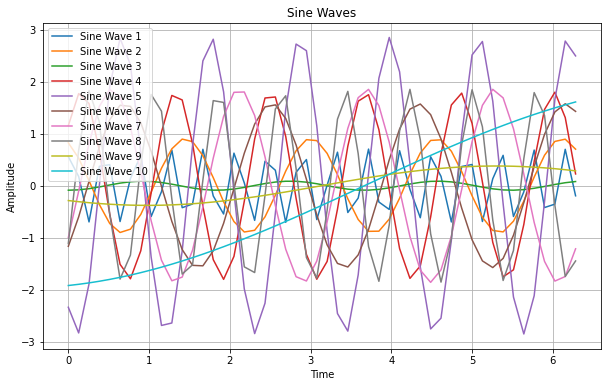

In [91]:
import matplotlib.pyplot as plt

def plot_sine_waves(waves_tensor):
    """
    Plot sine waves from a tensor of shape (n, t).

    Parameters:
    waves_tensor (torch.Tensor): Tensor of shape (n, t) containing the sine waves.
    """
    n, t = waves_tensor.shape
    t_values = torch.linspace(0, 2 * torch.pi, t).numpy()
    
    plt.figure(figsize=(10, 6))
    for i in range(n):
        wave = waves_tensor[i].detach().numpy()
        plt.plot(t_values, wave, label=f'Sine Wave {i+1}')
    
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine Waves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the sine waves
plot_sine_waves(output)


In [92]:
class SelectorWaveLayer(nn.Module):
    def __init__(self, n,m, t, phi_prev=False, w_prev=False):
        super(SelectorWaveLayer, self).__init__()
        self.n = n
        self.m = m
        self.t = t
        self.phi_prev = phi_prev
        self.w_prev = w_prev
        
        # Parameters A, w, phi
        
        self.w = nn.Parameter(torch.randn(m,n))
        self.phi = nn.Parameter(torch.randn(m,n))
        
        # Single phi_current parameter
        self.phi_current = nn.Parameter(torch.randn(1))
        
        if phi_prev:
            self.phi_previous = nn.Parameter(torch.randn(1))
        else:
            self.phi_previous = None
        
        # Single current_w parameter
        self.current_w = nn.Parameter(torch.randn(1))
        
        if w_prev:
            self.previous_w = nn.Parameter(torch.randn(1))
        else:
            self.previous_w = None

    def forward(self, t_vector, wave_input, phi_previous=None, w_previous=None):
        # Expand t_vector to match the shape of parameters
        t_vector = t_vector.unsqueeze(0).expand(self.n, -1)
        
        phi = self.phi
        phi_static = self.phi_current
        if self.phi_prev and phi_previous is not None:
            phi_static = phi_static + phi_previous
        phi = (phi + phi_static).unsqueeze(-1)
        
        # Calculate the angular frequency
        w = self.w
        w_static = self.current_w
        if self.w_prev and w_previous is not None:
            w_static = w_static + w_previous
        w = (w + w_static).unsqueeze(-1)
        #print(t_vector.shape, phi.shape, w.shape)
        # Calculate the sine wave
        #print(w.shape,t_vector.shape)
    
        sine_wave = 0.5 * torch.sin(w * t_vector +  phi) + 0.5
        #print(wave_input.shape)
        result = torch.einsum('ijk,jk->ik', sine_wave, wave_input)
        
        return result, phi_static , w_static

In [93]:
m=13
slayer = SelectorWaveLayer(n,m,t,phi_prev=True,w_prev=True)

In [94]:
x,a,b = slayer(t_vector,output,p,w)

In [95]:
x.shape

torch.Size([13, 50])

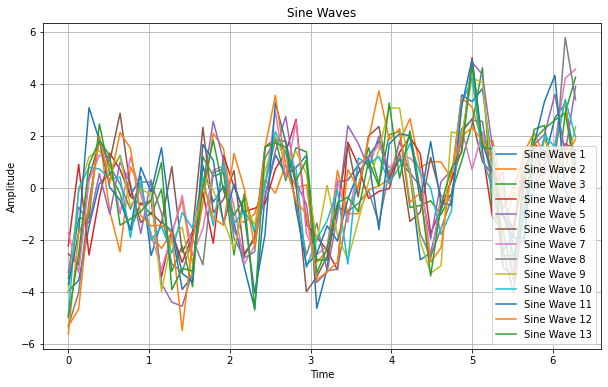

In [96]:
# Plot the sine waves
plot_sine_waves(x)